# **Parameter Efficient Fine Tuning using LoRA adapter**

Paper being referred: "*LORA: LOW-RANK ADAPTATION OF LARGE LANGUAGE MODELS*" (https://arxiv.org/pdf/2106.09685.pdf)

In [2]:
# Mount into drive

from google.colab import drive

drive.mount("/content/drive")

# Change directory to the package folder
#!! This should be the base directory of the project, this directory should look like the screenshot below.

%cd /content/drive/MyDrive/

# Verify the contents of the current folder
!ls

Mounted at /content/drive
/content/drive/MyDrive
'Colab Notebooks'		  'FT_Context Distillation_self.ipynb'
'Copy of Untitled document.gdoc'   peft_LoRA_on_RTE_v2.ipynb


# Set-up directories properly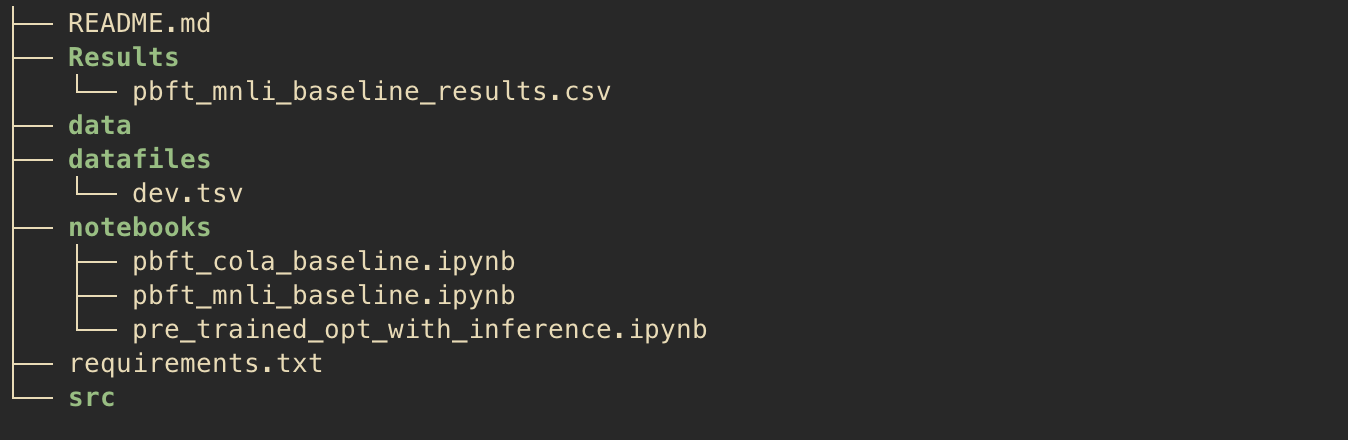

In [ ]:
# import os

# from requests import get
# from socket import gethostname, gethostbyname
# # ip = gethostbyname(gethostname())
# # curr_filename = get(f"http://{ip}:9000/api/sessions").json()[0]["name"]

# # if there is no notebooks folder, create one and move the notebook to that folder and cd into it
# if not os.path.exists('notebooks'):
#   %mkdir notebooks
#   %mv  notebooks/

# %cd notebooks/

# # check if "Results" folder exits in the base directly, else create one
# if not os. path.exists('../Results'):
#   %mkdir ../Results

# !ls


In [3]:
!pip install -q transformers accelerate bitsandbytes datasets torch peft tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [5]:
# Load required libraries

from datasets import load_dataset, ClassLabel
from sklearn.metrics import accuracy_score
from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification, AutoTokenizer, AdamW, AutoConfig
from peft import LoraConfig, get_peft_model
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

# Set seed, load RTE dataset

torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

rte_data = load_dataset("glue", "rte") # load rte data
hans_data = load_dataset("hans")

# preprocess RTE dataset
def preprocess_rte(batch):
    encoding = tokenizer(
        [f"{premise} Question: {hypothesis} Yes or No?" for premise, hypothesis in zip(batch["sentence1"], batch["sentence2"])],
        truncation=True,
        padding="max_length",
        max_length=128
    )
    return encoding

# # preprocess hans
# def preprocess_hans(batch):
#     encoding = tokenizer(
#         [f"{premise} Question: {hypothesis} Yes or No?" for premise, hypothesis in zip(batch["premise"], batch["hypothesis"])],
#         truncation=True,
#         padding="max_length",
#         max_length=128
#     )
#     if "labels" not in batch:
#         encoding["labels"] = batch["label"]
#     return encoding

# Ensure 'labels' column is correct for HANS
if "labels" in hans_data["validation"].column_names:
    print("'labels' column already exists in HANS. Skipping renaming.")
else:
    hans_data = hans_data.rename_column("label", "labels")

# Remove redundant 'label' column
if "label" in hans_data["validation"].column_names:
    hans_data = hans_data.remove_columns(["label"])

# Set format for PyTorch
hans_data = hans_data.with_format("torch")

# Preprocess HANS dataset
def preprocess_hans(batch):
    encoding = tokenizer(
        [f"{premise} Question: {hypothesis} Yes or No?" for premise, hypothesis in zip(batch["premise"], batch["hypothesis"])],
        truncation=True,
        padding="max_length",
        max_length=128
    )
    # Use 'labels' directly
    encoding["labels"] = batch["labels"]
    return encoding

# Load tokenizer and model config
tokenizer = AutoTokenizer.from_pretrained("facebook/opt-125m")
config = AutoConfig.from_pretrained("facebook/opt-125m", num_labels=2, hidden_dropout_prob=0.1, attention_probs_dropout_prob=0.1)

# Preprocess datasets
rte_data = rte_data.map(preprocess_rte, batched=True)
hans_data = hans_data.map(preprocess_hans, batched=True)

# Inspect the first few rows of the HANS dataset
# print(hans_data["validation"].to_pandas().head())


# # Set dataset format to PyTorch
# rte_data = rte_data.rename_column("label", "labels").with_format("torch")
# hans_data = hans_data.rename_column("label", "labels").with_format("torch")

# Split datasets
train_dataset = rte_data["train"]
eval_dataset = rte_data["validation"]
hans_eval_dataset = hans_data["validation"]

# Define compute metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}

# Define parameters for training experiments (per reference paper)

few_shot_sample_size = [2, 32, 128]  # number of examples for each class
num_epochs = 40
batch_size = 32
learning_rate = 1e-5
weight_decay = 0.0
warmup_ratio = 0.1
num_runs = 3

# Vaiables to store training results into CSV
results_df = pd.DataFrame(columns=["n", "rank", "run", "in_domain_accuracy", "out_of_domain_accuracy"])

# deine config for LoRA
# !note - params set per paper for varying ranks of the marices
# lora_config_r1 = LoraConfig(r=1, lora_alpha=8, lora_dropout=0.1, bias="none", task_type="SEQ_CLS", inference_mode=False)
# lora_config_r2 = LoraConfig(r=2, lora_alpha=8, lora_dropout=0.1, bias="none", task_type="SEQ_CLS", inference_mode=False)
# lora_config_r4 = LoraConfig(r=4, lora_alpha=8, lora_dropout=0.1, bias="none", task_type="SEQ_CLS", inference_mode=False)
# lora_config_r8 = LoraConfig(r=8, lora_alpha=8, lora_dropout=0.1, bias="none", task_type="SEQ_CLS", inference_mode=False)
# lora_config_r64 = LoraConfig(r=64, lora_alpha=8, lora_dropout=0.1, bias="none", task_type="SEQ_CLS", inference_mode=False)

# lora_configs = [lora_config_r1, lora_config_r2, lora_config_r4, lora_config_r8, lora_config_r64]
lora_configs = [
    LoraConfig(r=4, lora_alpha=8, lora_dropout=0.1, task_type="SEQ_CLS")
]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/584k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/69.0k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/621k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2490 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/277 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3000 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/7.02k [00:00<?, ?B/s]

hans.py:   0%|          | 0.00/5.22k [00:00<?, ?B/s]

The repository for hans contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hans.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/30000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/30000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/651 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

Map:   0%|          | 0/2490 [00:00<?, ? examples/s]

Map:   0%|          | 0/277 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

# **Experimentation loop**

In [8]:
import time
start_time = time.time()

for _, n in enumerate(tqdm(few_shot_sample_size)):
    for _, lora_config in enumerate(tqdm(lora_configs)):
      for run_idx in tqdm(range(num_runs)):  # repeat 10 times for each n
          # re-iniialize model for each run
          model = AutoModelForSequenceClassification.from_pretrained("facebook/opt-125m")
          model = get_peft_model(model, lora_config)
          optimizer = AdamW(model.parameters(), lr=learning_rate)

          # Select n random examples for each class from the original data
          indices_yes = [i for i, label in enumerate(train_dataset["label"]) if label == 0]
          indices_no = [i for i, label in enumerate(train_dataset["label"]) if label == 1]
          indices_yes = np.random.choice(indices_yes, n, replace=False)
          indices_no = np.random.choice(indices_no, n, replace=False)
          indices = np.concatenate([indices_yes, indices_no])

          # Select the examples for the new training set
          few_shot_train_dataset = train_dataset.select(indices)

          # Define training config
          # Total steps = (#samples/batch size) * epochs
          total_steps = (len(few_shot_train_dataset) // batch_size) * num_epochs

          training_args = TrainingArguments(
              output_dir = "./results",
              overwrite_output_dir = True,
              num_train_epochs = num_epochs,
              per_device_train_batch_size = batch_size,
              learning_rate = learning_rate,
              weight_decay = weight_decay,
              save_steps = 10_000,
              save_total_limit = 2,
              warmup_steps = int(warmup_ratio * total_steps),
          )

          # Define the trainer
          trainer = Trainer(
              model = model,
              args=training_args,
              train_dataset = train_dataset,
              compute_metrics = compute_metrics,
              optimizers=(optimizer, None),
          )

          # Train the model
          trainer.train()

          # Evaluate in-domain performance
          print(f"Evaluating in-domain performance for n={n}, rank={lora_config.r}...")
          eval_results_in_domain = trainer.evaluate(eval_dataset=eval_dataset)
          in_domain_accuracy = eval_results_in_domain["eval_accuracy"]

          # Print the in-domain evaluation results
          for key, value in eval_results_in_domain.items():
              print(f"In-domain {key}: {value}")

          # Evaluate out-of-domain performance
          print(f"Evaluating out-of-domain performance for n={n}, rank={lora_config.r}...")
          eval_results_out_domain = trainer.evaluate(eval_dataset=hans_eval_dataset)
          out_of_domain_accuracy = eval_results_out_domain["eval_accuracy"]

          # Print the out-of-domain evaluation results
          for key, value in eval_results_out_domain.items():
              print(f"Out-of-domain {key}: {value}")

          # Add the results to the DataFrame
          new_row = pd.DataFrame({
              "n": [n],
              "rank": [lora_config.r],
              "run": [run_idx],
              "in_domain_accuracy": [in_domain_accuracy],
              "out_of_domain_accuracy": [out_of_domain_accuracy]
          })
          results_df = pd.concat([results_df, new_row], ignore_index=True)

print(f'Finished training!!')
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

print(f"Time used: {elapsed_time:.2f} seconds")

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss
500,0.740200
1000,0.706000
1500,0.696800
2000,0.690300
2500,0.685200
3000,0.684900


Evaluating in-domain performance for n=2, rank=4...


In-domain eval_loss: 0.6801170706748962
In-domain eval_accuracy: 0.5740072202166066
In-domain eval_runtime: 1.9568
In-domain eval_samples_per_second: 141.56
In-domain eval_steps_per_second: 17.887
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=4...


<ipython-input-8-487e7e3866c9>:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


 33%|███▎      | 1/3 [28:01<56:02, 1681.40s/it]

Out-of-domain eval_loss: 0.7184489965438843
Out-of-domain eval_accuracy: 0.5011
Out-of-domain eval_runtime: 210.0715
Out-of-domain eval_samples_per_second: 142.809
Out-of-domain eval_steps_per_second: 17.851
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.719100
1000,0.702100
1500,0.693200
2000,0.686100
2500,0.684700
3000,0.680300


Evaluating in-domain performance for n=2, rank=4...


In-domain eval_loss: 0.6887184381484985
In-domain eval_accuracy: 0.555956678700361
In-domain eval_runtime: 1.9953
In-domain eval_samples_per_second: 138.826
In-domain eval_steps_per_second: 17.541
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=4...




 67%|██████▋   | 2/3 [54:52<27:19, 1639.94s/it]

Out-of-domain eval_loss: 0.6956923007965088
Out-of-domain eval_accuracy: 0.5194
Out-of-domain eval_runtime: 210.0398
Out-of-domain eval_samples_per_second: 142.83
Out-of-domain eval_steps_per_second: 17.854
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.719100
1000,0.702100
1500,0.693200
2000,0.686100
2500,0.684700
3000,0.680300


Evaluating in-domain performance for n=2, rank=4...


In-domain eval_loss: 0.6887184381484985
In-domain eval_accuracy: 0.555956678700361
In-domain eval_runtime: 1.9516
In-domain eval_samples_per_second: 141.932
In-domain eval_steps_per_second: 17.934
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=2, rank=4...




100%|██████████| 3/3 [1:21:39<00:00, 1633.31s/it]

 33%|███▎      | 1/3 [1:21:39<2:43:19, 4899.99s/it]

Out-of-domain eval_loss: 0.6956923007965088
Out-of-domain eval_accuracy: 0.5194
Out-of-domain eval_runtime: 209.6627
Out-of-domain eval_samples_per_second: 143.087
Out-of-domain eval_steps_per_second: 17.886
Out-of-domain epoch: 40.0



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.719600
1000,0.702100
1500,0.693100
2000,0.685900
2500,0.684600
3000,0.680100


Evaluating in-domain performance for n=32, rank=4...


In-domain eval_loss: 0.6885373592376709
In-domain eval_accuracy: 0.5451263537906137
In-domain eval_runtime: 1.9533
In-domain eval_samples_per_second: 141.809
In-domain eval_steps_per_second: 17.918
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=4...




 33%|███▎      | 1/3 [26:46<53:33, 1606.59s/it]

Out-of-domain eval_loss: 0.6952991485595703
Out-of-domain eval_accuracy: 0.5193333333333333
Out-of-domain eval_runtime: 209.0645
Out-of-domain eval_samples_per_second: 143.496
Out-of-domain eval_steps_per_second: 17.937
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.719600
1000,0.702100
1500,0.693100
2000,0.685900
2500,0.684600
3000,0.680100


Evaluating in-domain performance for n=32, rank=4...


In-domain eval_loss: 0.6885373592376709
In-domain eval_accuracy: 0.5451263537906137
In-domain eval_runtime: 1.9456
In-domain eval_samples_per_second: 142.373
In-domain eval_steps_per_second: 17.989
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=4...




 67%|██████▋   | 2/3 [53:31<26:45, 1605.87s/it]

Out-of-domain eval_loss: 0.6952991485595703
Out-of-domain eval_accuracy: 0.5193333333333333
Out-of-domain eval_runtime: 209.166
Out-of-domain eval_samples_per_second: 143.427
Out-of-domain eval_steps_per_second: 17.928
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.719600
1000,0.702100
1500,0.693100
2000,0.685900
2500,0.684600
3000,0.680100


Evaluating in-domain performance for n=32, rank=4...


In-domain eval_loss: 0.6885373592376709
In-domain eval_accuracy: 0.5451263537906137
In-domain eval_runtime: 1.9668
In-domain eval_samples_per_second: 140.836
In-domain eval_steps_per_second: 17.795
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=32, rank=4...




100%|██████████| 3/3 [1:20:20<00:00, 1606.76s/it]

 67%|██████▋   | 2/3 [2:42:00<1:20:53, 4853.11s/it]

Out-of-domain eval_loss: 0.6952991485595703
Out-of-domain eval_accuracy: 0.5193333333333333
Out-of-domain eval_runtime: 210.4674
Out-of-domain eval_samples_per_second: 142.54
Out-of-domain eval_steps_per_second: 17.817
Out-of-domain epoch: 40.0



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.720900
1000,0.702300
1500,0.693200
2000,0.686000
2500,0.684500
3000,0.680100


Evaluating in-domain performance for n=128, rank=4...


In-domain eval_loss: 0.688573956489563
In-domain eval_accuracy: 0.555956678700361
In-domain eval_runtime: 1.9986
In-domain eval_samples_per_second: 138.596
In-domain eval_steps_per_second: 17.512
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=4...




 33%|███▎      | 1/3 [26:49<53:38, 1609.49s/it]

Out-of-domain eval_loss: 0.6953673958778381
Out-of-domain eval_accuracy: 0.5195
Out-of-domain eval_runtime: 210.6082
Out-of-domain eval_samples_per_second: 142.445
Out-of-domain eval_steps_per_second: 17.806
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.720900
1000,0.702300
1500,0.693200
2000,0.686000
2500,0.684500
3000,0.680100


Evaluating in-domain performance for n=128, rank=4...


In-domain eval_loss: 0.688573956489563
In-domain eval_accuracy: 0.555956678700361
In-domain eval_runtime: 1.9593
In-domain eval_samples_per_second: 141.376
In-domain eval_steps_per_second: 17.863
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=4...




 67%|██████▋   | 2/3 [53:37<26:48, 1608.66s/it]

Out-of-domain eval_loss: 0.6953673958778381
Out-of-domain eval_accuracy: 0.5195
Out-of-domain eval_runtime: 209.106
Out-of-domain eval_samples_per_second: 143.468
Out-of-domain eval_steps_per_second: 17.933
Out-of-domain epoch: 40.0


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.720900
1000,0.702300
1500,0.693200
2000,0.686000
2500,0.684500
3000,0.680100


Evaluating in-domain performance for n=128, rank=4...


In-domain eval_loss: 0.688573956489563
In-domain eval_accuracy: 0.555956678700361
In-domain eval_runtime: 1.9538
In-domain eval_samples_per_second: 141.773
In-domain eval_steps_per_second: 17.914
In-domain epoch: 40.0
Evaluating out-of-domain performance for n=128, rank=4...




100%|██████████| 3/3 [1:20:25<00:00, 1608.39s/it]

100%|██████████| 3/3 [4:02:25<00:00, 4848.49s/it]

Out-of-domain eval_loss: 0.6953673958778381
Out-of-domain eval_accuracy: 0.5195
Out-of-domain eval_runtime: 209.5383
Out-of-domain eval_samples_per_second: 143.172
Out-of-domain eval_steps_per_second: 17.896
Out-of-domain epoch: 40.0
Finished training!!
Time used: 14545.49 seconds


In [9]:
# Group the results by number of examples in few-shot learning runs and compute the average and maximum performance for each group
grouped_results = results_df.groupby(['n', 'rank'])

average_in_domain_accuracy = grouped_results['in_domain_accuracy'].mean()
maximum_in_domain_accuracy = grouped_results['in_domain_accuracy'].max()

average_out_of_domain_accuracy = grouped_results['out_of_domain_accuracy'].mean()
maximum_out_of_domain_accuracy = grouped_results['out_of_domain_accuracy'].max()

# Print the results for each 'n' and each rank
for n in few_shot_sample_size:
    for lora_config in lora_configs:
      print(f"For n={n}:")
      print(f"For rank={lora_config.r}:")
      print(f"Average in-domain accuracy: {average_in_domain_accuracy[n]}")
      print(f"Maximum in-domain accuracy: {maximum_in_domain_accuracy[n]}")
      print(f"Average out-of-domain accuracy: {average_out_of_domain_accuracy[n]}")
      print(f"Maximum out-of-domain accuracy: {maximum_out_of_domain_accuracy[n]}")
      print("\n")

# Compute and print the overall average and maximum performance
print("Overall:")
print(f"Average in-domain accuracy: {results_df['in_domain_accuracy'].mean()}")
print(f"Maximum in-domain accuracy: {results_df['in_domain_accuracy'].max()}")
print(f"Average out-of-domain accuracy: {results_df['out_of_domain_accuracy'].mean()}")
print(f"Maximum out-of-domain accuracy: {results_df['out_of_domain_accuracy'].max()}")


For n=2:
For rank=4:
Average in-domain accuracy: rank
4    0.561974
Name: in_domain_accuracy, dtype: float64
Maximum in-domain accuracy: rank
4    0.574007
Name: in_domain_accuracy, dtype: float64
Average out-of-domain accuracy: rank
4    0.5133
Name: out_of_domain_accuracy, dtype: float64
Maximum out-of-domain accuracy: rank
4    0.5194
Name: out_of_domain_accuracy, dtype: float64


For n=32:
For rank=4:
Average in-domain accuracy: rank
4    0.545126
Name: in_domain_accuracy, dtype: float64
Maximum in-domain accuracy: rank
4    0.545126
Name: in_domain_accuracy, dtype: float64
Average out-of-domain accuracy: rank
4    0.519333
Name: out_of_domain_accuracy, dtype: float64
Maximum out-of-domain accuracy: rank
4    0.519333
Name: out_of_domain_accuracy, dtype: float64


For n=128:
For rank=4:
Average in-domain accuracy: rank
4    0.555957
Name: in_domain_accuracy, dtype: float64
Maximum in-domain accuracy: rank
4    0.555957
Name: in_domain_accuracy, dtype: float64
Average out-of-domain 

In [12]:
# Define the filename
curr_filename = "peft_Lora_RTE.csv"

# Save the DataFrame to the current directory
results_df.to_csv(curr_filename, sep=',', index=False)
print(f"Results saved to {curr_filename} in the current directory.")



Results saved to peft_Lora_RTE.csv in the current directory.


In [10]:
# Save the DataFrame to a CSV file
results_df.to_csv(f'../Results/{curr_filename.split(".")[0]}.csv', sep = ',', index=False)

NameError: name 'curr_filename' is not defined

In [ ]:
# # disconnect runtime
from google.colab import runtime
runtime.unassign()